In [ ]:
import warnings
from collections import defaultdict

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from desmin_reconstruction.colocalization.coordinate_based import (
    coordinate_based_colocalization,
    coordinate_based_colocalization_liu,
)
from desmin_reconstruction.plotting.lineplots import line_and_bandplot
from desmin_reconstruction.preprocessing.bbox import BoundingSquare, filter_bounded
from desmin_reconstruction.preprocessing.storm import align_patch
from desmin_reconstruction.utils.array import midpoints
from tqdm import tqdm


COLOR_DICT = {"desmin": "#FF0000", "actinin": "#00FF00", "actin": "#0000FF"}
LABEL_DICT = {"desmin": "Desmin", "actin": "Actin", "actinin": "α-actinin"}
scatter_kwargs = {"alpha": 0.3, "s": 0.2}

df = pl.read_csv("../data/results/desmin_alphaactinin_600nm_aligned.csv")
out = df.partition_by("probe")

In [2]:
points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("desmin", "actinin"))
}
points["desmin"].shape


(59957, 3)

In [3]:
x0s = (2, 6, 10, 14, 18, 1, 5, 9, 13, 17, 0, 4, 8, 12, 16, 15)
y0s = (9, 9, 9, 9, 9, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, -3)
bboxes = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [ ]:
cbc_all = defaultdict(list)
kcbc_all = defaultdict(list)

In [ ]:
for bbox in tqdm(bboxes):
    sq1 = {k: filter_bounded(v, bbox) for k, v in points.items()}
    cbc_all["actinin"].append(
        coordinate_based_colocalization(
            sq1["desmin"], sq1["actinin"], r_max=1.5, bins=30
        )
    )
    kcbc_all["actinin"].append(
        coordinate_based_colocalization_liu(
            sq1["desmin"],
            sq1["actinin"],
            r_max=1.5,
            bins=30,
            sides=np.asarray([4.0, 4.0, 1.0]),
        )
    )

100%|██████████| 16/16 [00:50<00:00,  3.13s/it]


  0%|          | 0/4000 [00:00<?, ?it/s]

100%|██████████| 25/25 [02:35<00:00,  6.24s/it]


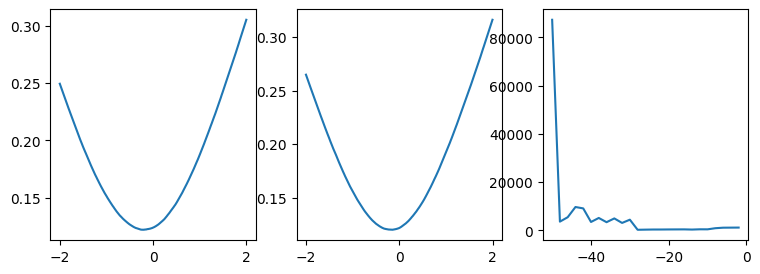

In [5]:
df = pl.read_csv("../data/results/actin_desmin_600nm_filtered.csv")
out = df.partition_by("probe")

points = {
    name: out[i].select(["x", "y", "z"]).to_numpy()
    for i, name in enumerate(("actin", "desmin"))
}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    transform_fn, metrics = align_patch(
        points,
        tilt_sweep_values=np.arange(-2, 2, 0.001),
        rotation_sweep_values=np.arange(-50, 0.0, 2.0),
        min_cluster_size=200,
        min_samples=1,
        clustering_species="actin",
    )

fig, axes = plt.subplots(1, len(metrics), figsize=(9, 3))
for ax, metric in zip(axes, metrics):
    ax.plot(*metric)

points_actin = {k: transform_fn(v) for k, v in points.items()}

x0s = (3, 7, 7, 11, 11, 11, 15, 15, 15, 19)
y0s = (-2, -1.5, -5.5, -1, -5, -9, 0.5, -3.5, -7.5, -2)
bboxes_actin = [BoundingSquare(x0, y0, side=4) for x0, y0 in zip(x0s, y0s)]

In [6]:
for bbox in tqdm(bboxes_actin):
    sq1 = {k: filter_bounded(v, bbox) for k, v in points_actin.items()}
    cbc_all["actin"].append(
        coordinate_based_colocalization(sq1["desmin"], sq1["actin"], r_max=1.5, bins=30)
    )
    kcbc_all["actin"].append(
        coordinate_based_colocalization_liu(
            sq1["desmin"],
            sq1["actin"],
            r_max=1.5,
            bins=30,
            sides=np.asarray([4.0, 4.0, 1.0]),
        )
    )

100%|██████████| 10/10 [00:14<00:00,  1.43s/it]


In [46]:
corr_score_bins = np.linspace(-1, 1, 50)
cbc_hist = jax.tree.map(
    lambda x: jnp.histogram(x, corr_score_bins, density=True)[0], cbc_all
)
kcbc_hist = jax.tree.map(
    lambda x: jnp.histogram(x, corr_score_bins, density=True)[0], kcbc_all
)

Text(0, 0.5, 'Probability')

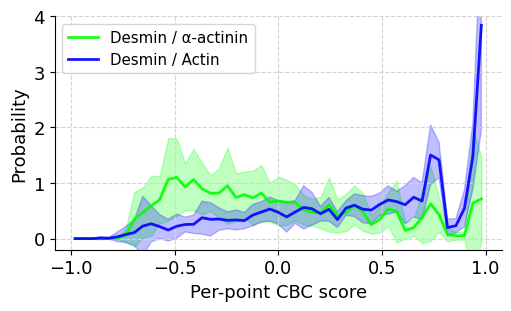

In [47]:
plt.rc("font", size=13)

fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
for protein, offset in zip(("actinin", "actin"), (-0.02, 0.02)):
    ax = line_and_bandplot(
        ax,
        midpoints(corr_score_bins),
        np.mean(cbc_hist[protein], axis=0),
        np.std(cbc_hist[protein], axis=0),
        color=COLOR_DICT[protein],
        label=f"Desmin / {LABEL_DICT[protein]}",
        linewidth=2.0,
        alpha=0.9,
        alpha_band=0.25,
    )
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.legend(loc="upper left", fontsize="small")
ax.set_ylim((-0.2, 4.0))
ax.set_xlabel("Per-point CBC score")
ax.set_ylabel("Probability")

Text(0, 0.5, 'Probability')

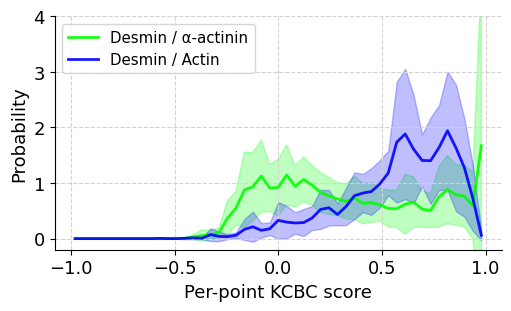

In [48]:
plt.rc("font", size=13)

fig, ax = plt.subplots(1, 1, figsize=(5, 3), constrained_layout=True)
for protein, offset in zip(("actinin", "actin"), (-0.02, 0.02)):
    ax = line_and_bandplot(
        ax,
        midpoints(corr_score_bins),
        np.mean(kcbc_hist[protein], axis=0),
        np.std(kcbc_hist[protein], axis=0),
        color=COLOR_DICT[protein],
        label=f"Desmin / {LABEL_DICT[protein]}",
        linewidth=2.0,
        alpha=0.9,
        alpha_band=0.25,
    )
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(ls="--", color="lightgray")
ax.legend(loc="upper left", fontsize="small")
ax.set_ylim((-0.2, 4.0))
ax.set_xlabel("Per-point KCBC score")
ax.set_ylabel("Probability")